# Latent Dirichlet Allocation (LDA)

This notebook attempts to use LDA to model the topics in a group of Bugzilla bugs through text analysis.

Also want to use [this approach](https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/) to use grid search to determine the most meaningful number of topics that exist in the text.

# Google Colaborator Setup

This section contains cells to set up the Google Colaborator environment to run this notebook. The following are needed:

* Clone the Github repository
* Install Spacy
* Install pyLDAVis

## Note: The runtime may need to be restarted after installing Spacy.

In [1]:
from datetime import date
from datetime import time
from datetime import datetime
from time import sleep
from math import ceil
from dateutil import parser
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import spacy

In [2]:
!pip install pyLDAVis

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 1.7 MB 6.2 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 829 kB 6.4 MB/s eta 0:00:01
     |████████████████████████████████| 473 kB 14.4 MB/s eta 0:00:01
     |████████████████████████████████| 303 kB 17.7 MB/s eta 0:00:01
     |████████████████████████████████| 24.9 MB 17.9 MB/s eta 0:00:01   |█▌                              | 1.2 MB 8.8 MB/s eta 0:00:03     |███████████████████▌            | 15.2 MB 8.8 MB/s eta 0:00:02
  Created wheel for pyLDAVis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136870 sha256=c4334b60b5c1b19bc8bf1fa2054f731ff8c382195f861acdf3371f5af37d3641
  Stored in directory: /home/vscode/.cache/pip/wheels/90/61/ec/9dbe9efc3acf9c4e37ba70fbbcc3f3a0ebd121060aa593181a
  C

# Loading Bugzilla Data

In [3]:
url = 'https://github.com/HSV-AI/bug-analysis/raw/master/data/df-xtext.parquet.gzip'
df = pd.read_parquet(url)

In [4]:
#Global Imports
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy

Now let's take a look at the content of the bugs that we retrieved.

First we can check the distribution of bugs across the defined components:

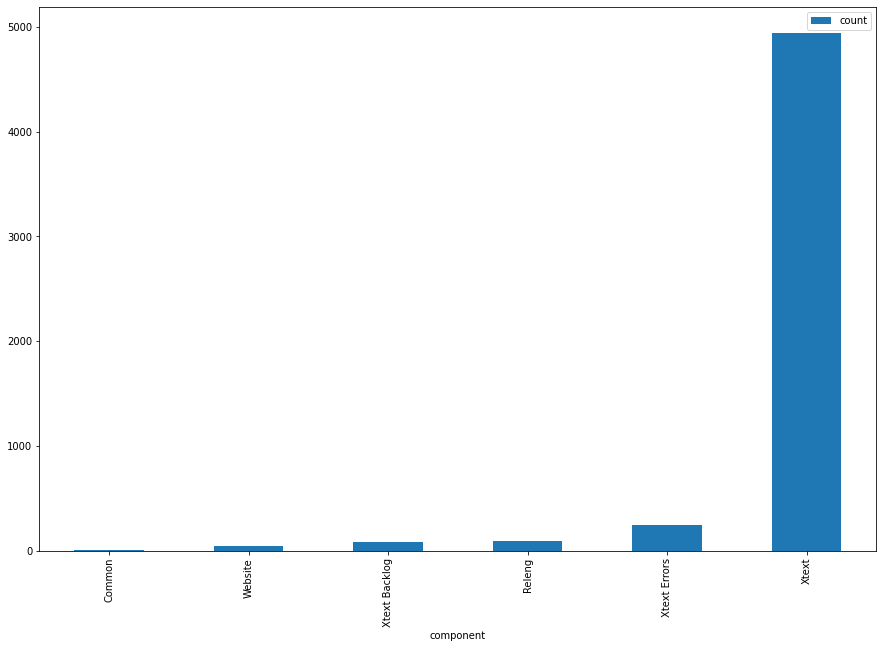

In [5]:
grouped = df.loc[:,['id','component']].groupby('component').count()
grouped.columns = ['count']
grouped.sort_values(by='count').plot(kind='bar', figsize=(15,10))
plt.show()

# Cleaning Data

If you have ever worked with software bugs, you know that many of them are lacking enough information to be useful. On the other hand, some will take on a life of their own and change direction over time.

In this analysis, we will try to remove the bugs that have little text as well as those that have an overwhelming length of text.

We start by showing the distribution of the length, followed by calculation of the 3*sigma cuttof points. Seeing that this method will not work for this non-normal distribution, we use the Interquartile Range (IQR) instead.

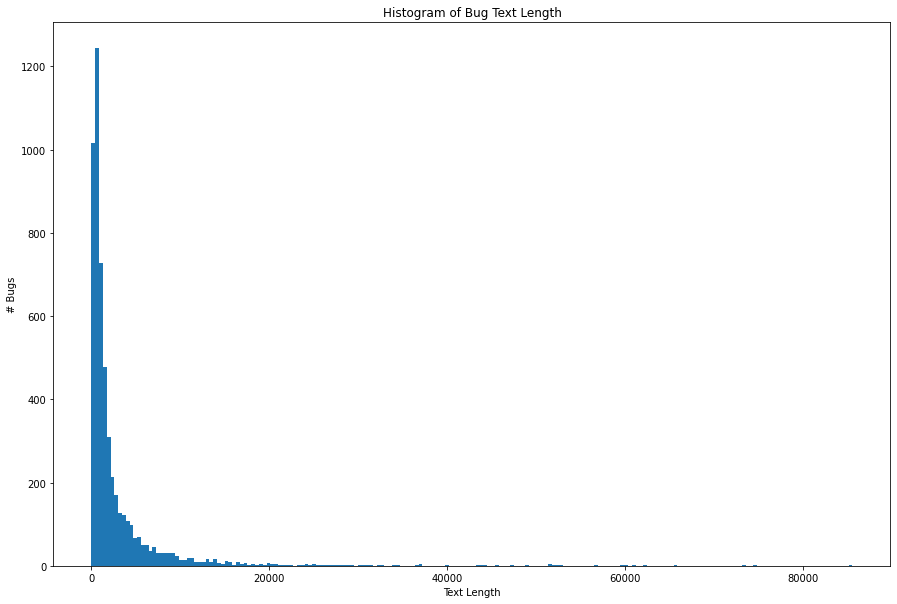

Min/Max length of any bug is 17/85577

Mean of text length is 2859
 
Standard Deviation of the text length is 5623

3 Sigma cuttoff values are lower: -14009 and upper: 19728

Interquartile Range is 2195

IQR cuttoff values are lower: -2753 and upper: 6026



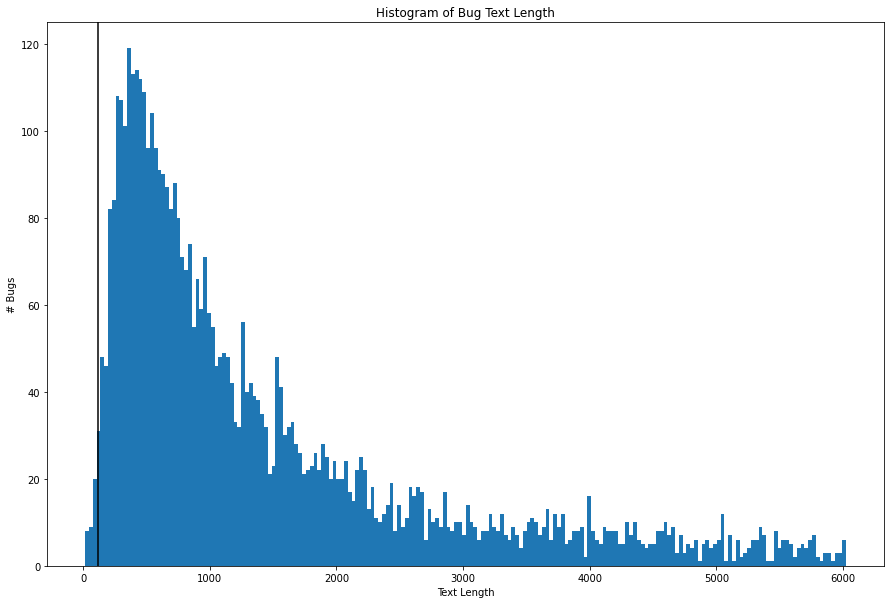

Using a manually defined lower value of 120 (See Vertical Black Line Above)

The resulting set contains 4755 bugs



In [6]:
df['length'] = df['text'].str.len()
text_arr = df.loc[:,'length'].values

# Plot a histogram of the text length
plt.figure(figsize=(15,10))
plt.xlabel('Text Length')
plt.ylabel('# Bugs')
plt.title('Histogram of Bug Text Length')
plt.hist(text_arr, bins=200)
plt.show()

print('Min/Max length of any bug is %d/%d\n'%(np.min(text_arr), np.max(text_arr)))

# Find the values bounding the 98 percentile
# May want to filter these later
mean = np.mean(text_arr)
print('Mean of text length is %d\n ' % mean)
stdev = np.std(text_arr)
print('Standard Deviation of the text length is %d\n' % stdev)
#Compute 3sigma
sigma = 3*stdev
lower = mean - sigma
upper = mean + sigma

print('3 Sigma cuttoff values are lower: %d and upper: %d\n' % (lower, upper))

q25, q75 = np.percentile(text_arr, 25), np.percentile(text_arr, 75)
iqr = q75 - q25
print('Interquartile Range is %d\n' % iqr)

cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off

print('IQR cuttoff values are lower: %d and upper: %d\n' % (lower, upper))

trimmedDF = df.loc[(df['length'] > lower) & (df['length'] < upper)]

# Let's get a look at these values
text_arr = trimmedDF.loc[:,'length'].values

# Plot a histogram of the text length
plt.figure(figsize=(15,10))
plt.xlabel('Text Length')
plt.ylabel('# Bugs')
plt.title('Histogram of Bug Text Length')
plt.axvline(x=120, color='k')
plt.hist(text_arr, bins=200)
plt.show()

print("Using a manually defined lower value of 120 (See Vertical Black Line Above)\n")
lower = 120
trimmedDF = df.loc[(df['length'] > lower) & (df['length'] < upper)]
text_arr = trimmedDF.loc[:,'length'].values
print('The resulting set contains %d bugs\n' % len(text_arr))

# Create a Tokenize Method
This method provides a simple list of words from the text. We will go ahead and run this against the bugs that we have loaded to find the total number of tokens.


In [7]:
nlp = spacy.load("en_core_web_sm")

exception_regex = re.compile(r".+Exception[^\n].*\s+at", re.MULTILINE | re.IGNORECASE)
greater_regex = re.compile(r"^> .*$", re.MULTILINE | re.IGNORECASE)
gerrit_created_regex = re.compile(r"New Gerrit change created: [^\ ]+", re.MULTILINE | re.IGNORECASE)
gerrit_merge_regex = re.compile(r"Gerrit change [^\s]+ was merged to [^\.]+\.", re.MULTILINE | re.IGNORECASE)
gerrit_commit_regex = re.compile(r"Commit: [^\ ]+", re.MULTILINE | re.IGNORECASE)

filter = ['VERB', 'NOUN', 'PROPN']

def tokenize(text):
    text = greater_regex.sub("", text)
    text = exception_regex.sub("", text)
    text = gerrit_created_regex.sub("", text)
    text = gerrit_merge_regex.sub("", text)
    text = gerrit_commit_regex.sub("", text)
    filtered_tokens = []
    
    doc = nlp(text)
    for sent in doc.sents:
        for token in sent:
            if re.fullmatch('[a-zA-Z]+', token.text):
#            if token.pos_ in filter and re.fullmatch('[a-zA-Z]+', token.text):
                filtered_tokens.append(token.lemma_)
    return filtered_tokens



Let's run this tokenizer across all of our text and see how many words we have.

In [ ]:
# The following piece will count up all of the words in the vocabulary. Usefull information, but it takes a while.
totalvocab = []
count = 0

for i in trimmedDF.loc[:,'text']:
#     count = count+1
    allwords = tokenize(i)
    totalvocab.extend(allwords)
# #     if count > 20:
#         break
print('Total word count: '+str(len(totalvocab)))
print('Total unique words: '+str(len(set(totalvocab))))

# Create a CountVectorizer

Need to figure out what the optimum data sparsity is here. Also need to figure out a bettwer set of stop words.

In [34]:
from sklearn.feature_extraction.text import CountVectorizer
tf_vectorizer = CountVectorizer(max_df=0.5, min_df=10, tokenizer=tokenize)
# tf_vectorizer = CountVectorizer(min_df=5, stop_words='english', tokenizer=tokenize)
%time tf = tf_vectorizer.fit_transform(trimmedDF.loc[:,'text'])
tf_feature_names = tf_vectorizer.get_feature_names()
# Materialize the sparse data
dense = tf.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Data Sparsicity: ", ((dense > 0).sum()/dense.size)*100, "%")
print(len(tf_vectorizer.stop_words_))

CPU times: user 6min 12s, sys: 4.05 s, total: 6min 16s
Wall time: 2min 38s
Data Sparsicity:  2.5432907759169248 %
12064


In [35]:
default_vectorizer = CountVectorizer()
# tf_vectorizer = CountVectorizer(min_df=5, stop_words='english', tokenizer=tokenize)
%time default_tf = default_vectorizer.fit_transform(trimmedDF.loc[:,'text'])
tf_feature_names = default_vectorizer.get_feature_names()
# Materialize the sparse data
dense = default_tf.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Data Sparsicity: ", ((dense > 0).sum()/dense.size)*100, "%")

print(len(default_vectorizer.stop_words_))

CPU times: user 716 ms, sys: 4.01 ms, total: 720 ms
Wall time: 719 ms
Data Sparsicity:  0.3036447970613883 %
0


In [33]:
min_vectorizer = CountVectorizer(min_df=10)
# tf_vectorizer = CountVectorizer(min_df=5, stop_words='english', tokenizer=tokenize)
%time min_tf = min_vectorizer.fit_transform(trimmedDF.loc[:,'text'])
tf_feature_names = min_vectorizer.get_feature_names()
# Materialize the sparse data
dense = min_tf.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Data Sparsicity: ", ((dense > 0).sum()/dense.size)*100, "%")

print(len(min_vectorizer.stop_words_))

CPU times: user 647 ms, sys: 46 µs, total: 647 ms
Wall time: 647 ms
Data Sparsicity:  2.1439667269908447 %
28593


# LDA

For LDA, check the perplexity. The lower the better.

In [20]:
from sklearn.decomposition import LatentDirichletAllocation

# Run LDA
%time lda = LatentDirichletAllocation(n_components=15, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

print("\nLog Likelihood: %d ## Perplexity: %d\n" % ((lda.score(tf)), lda.perplexity(tf)))

# Print the top 5 words in each topic
num_words = 5
print('LDA Topics: ')
for topic_idx, topic in enumerate(lda.components_):
    print ("Topic %d:" % (topic_idx), " ".join([tf_feature_names[i] for i in topic.argsort()[:-num_words - 1:-1]]))



CPU times: user 17.3 s, sys: 196 ms, total: 17.5 s
Wall time: 9.18 s

Log Likelihood: -2025776 ## Perplexity: 636

LDA Topics: 
Topic 0: patch create attachment use add
Topic 1: import expression package xcore operator
Topic 2: xtext project build file use
Topic 3: class type java test method
Topic 4: return null method object string
Topic 5: content proposal assist injector template
Topic 6: grammar rule use model type
Topic 7: set resolve close xtend generate
Topic 8: error editor file message xtext
Topic 9: b c launch p d
Topic 10: resource reference use uri index
Topic 11: serializer performance serialize serialization memory
Topic 12: report follow present status id
Topic 13: line change api document comment
Topic 14: extension register epackage ecore genmodel


# Grid Search Optimization

We can run Grid Search across a list of parameters to identify the optimal parameters to use for the desired outcome.

In [36]:
# From: https://stackoverflow.com/questions/52986253/scoring-strategy-of-sklearn-model-selection-gridsearchcv-for-latentdirichletallo
class MyLDAWithPerplexityScorer(LatentDirichletAllocation):

    def score(self, X, y=None):

        # You can change the options passed to perplexity here
        score = super(MyLDAWithPerplexityScorer, self).perplexity(X, sub_sampling=False)

        # Since perplexity is lower for better, so we do negative
        return -1*score

In [39]:
from sklearn.model_selection import GridSearchCV

# Define Search Param
search_params = {'n_components': [6, 8, 10], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = MyLDAWithPerplexityScorer(learning_method='online')

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(tf)

/opt/tools/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=MyLDAWithPerplexityScorer(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_components': [6, 8, 10], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [40]:
# Best Model
lda = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", lda.perplexity(tf))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 6}
Best Log Likelihood Score:  -755.5412983790087
Model Perplexity:  593.2621784075608


# Measure Topic Distribution

In [41]:
topic_labels = []
for topic_idx, topic in enumerate(lda.components_):
    label_string = "Topic "+str(topic_idx)+ ": "+" ".join([tf_feature_names[i] for i in topic.argsort()[:-1 - 1:-1]])
    topic_labels.append(label_string)
    print(label_string)


Topic 0: 186692
Topic 1: 1303
Topic 2: 0852
Topic 3: 2100
Topic 4: 140435
Topic 5: 200958


In [42]:
def getLDATopic(row):
    try:
        tf_text = tf_vectorizer.transform([row['text']])
        doc_topic_dist = np.matrix(lda.transform(tf_text))
        #quick and dirty for now. May need to check for separation of values
        return doc_topic_dist.argmax()
    except:
        print(row)
    return -1.0
            
%time trimmedDF.loc[:,'topic'] = trimmedDF.apply(getLDATopic, axis=1)


CPU times: user 6min 15s, sys: 4 s, total: 6min 19s
Wall time: 2min 41s


/opt/tools/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/tools/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [43]:
import sklearn.metrics as metrics

print("Homogeneity: %0.3f" % metrics.homogeneity_score(trimmedDF.loc[:,'component'], trimmedDF.loc[:,'topic']))
print("Completeness: %0.3f" % metrics.completeness_score(trimmedDF.loc[:,'component'], trimmedDF.loc[:,'topic']))
print("V-measure: %0.3f" % metrics.v_measure_score(trimmedDF.loc[:,'component'], trimmedDF.loc[:,'topic']))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(trimmedDF.loc[:,'component'], trimmedDF.loc[:,'topic']))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(tf, trimmedDF.loc[:,'topic'], sample_size=1000))


Homogeneity: 0.203
Completeness: 0.042
V-measure: 0.070
Adjusted Rand-Index: 0.016
Silhouette Coefficient: -0.144


# Visualize the Results

This section uses several methods to visualize the results of the LDA.

Using PCA, create a 2D Visualizaton of the TF/IDF Matrix.

Components per Topic:


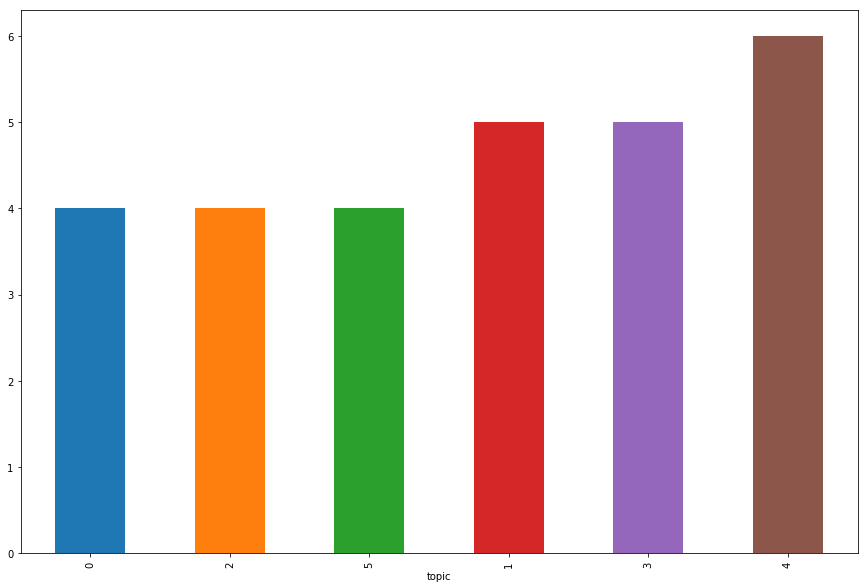

Bugs per Topic:


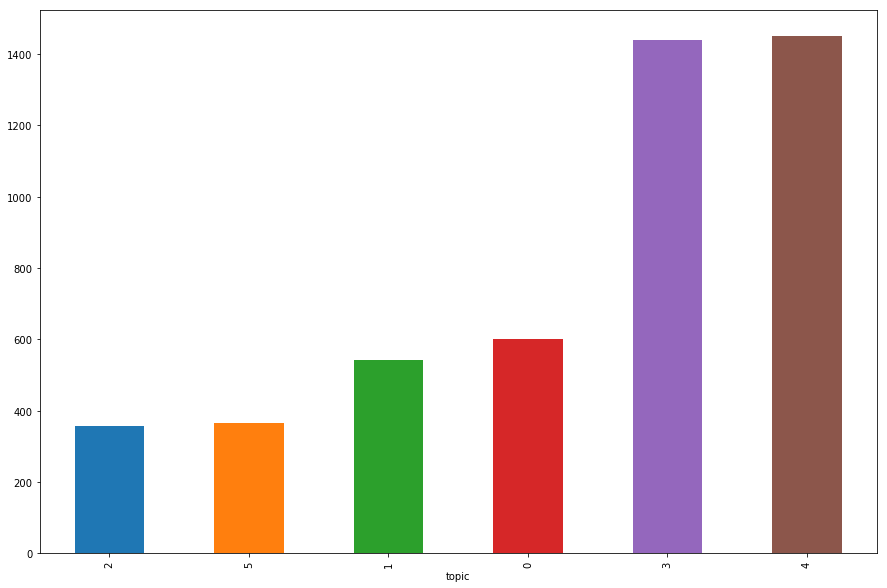

In [44]:
print("Components per Topic:")
grouped = trimmedDF.loc[:,['id','component','topic']].groupby('topic').component.nunique()
grouped.columns = ['count', 'component']
grouped.sort_values().plot(kind='bar', figsize=(15,10))
plt.show()

print("Bugs per Topic:")
grouped = trimmedDF.loc[:,['id','component','topic']].groupby('topic').component.count()
grouped.columns = ['count', 'component']
grouped.sort_values().plot(kind='bar', figsize=(15,10))
plt.show()



In [45]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer, mds='tsne')
pyLDAvis.display(panel)


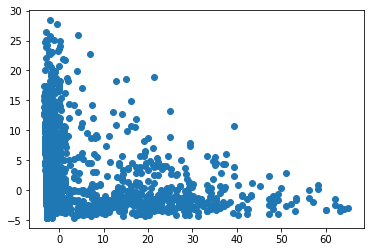

In [46]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

X = tf.todense()

pca = PCA(n_components=2).fit(X)
data2D = pca.transform(X)
plt.scatter(data2D[:,0], data2D[:,1])

plt.show()


/opt/tools/anaconda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


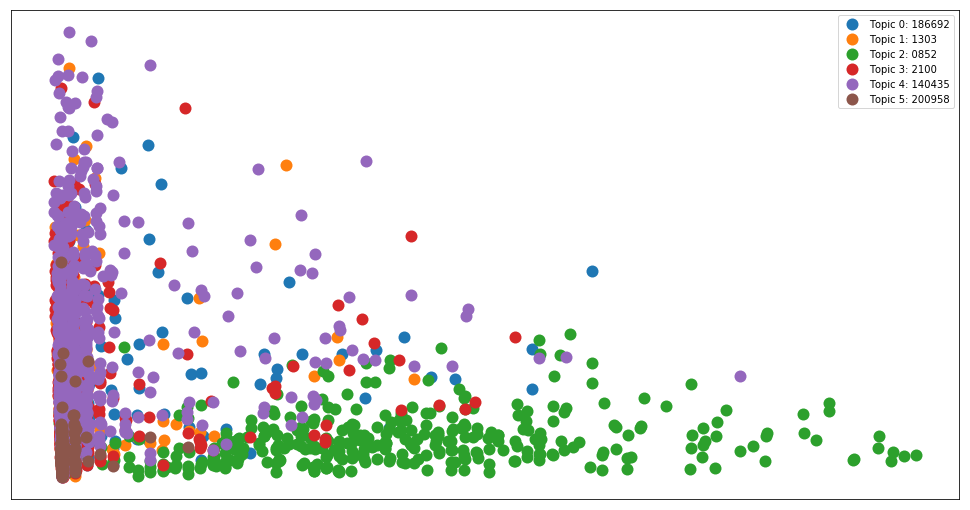

In [47]:
xs, ys = data2D[:, 0], data2D[:, 1]
# df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=trimmedDF.loc[:,'id'])) 
df = pd.DataFrame(dict(x=xs, y=ys, label=trimmedDF.loc[:,'topic'], title=trimmedDF.loc[:,'id'])) 

#group by cluster
groups = df.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
#            label=cluster_names[name], color=cluster_colors[name],
#            label=name,
            label=topic_labels[name],
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the bug id
#for i in range(len(df)):
#    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=8)  

plt.show() #show the plot


# I'll have another

Now try the same thing with MDS for reducing to 2 dimensions.

CPU times: user 32min 59s, sys: 5min 23s, total: 38min 22s
Wall time: 9min 37s


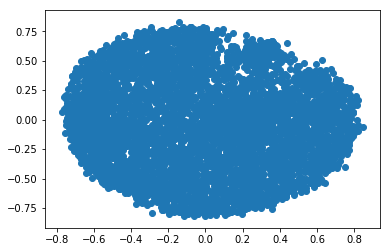

In [48]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tf)

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

%time pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
plt.scatter(pos[:,0], pos[:,1])

plt.show()



/opt/tools/anaconda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


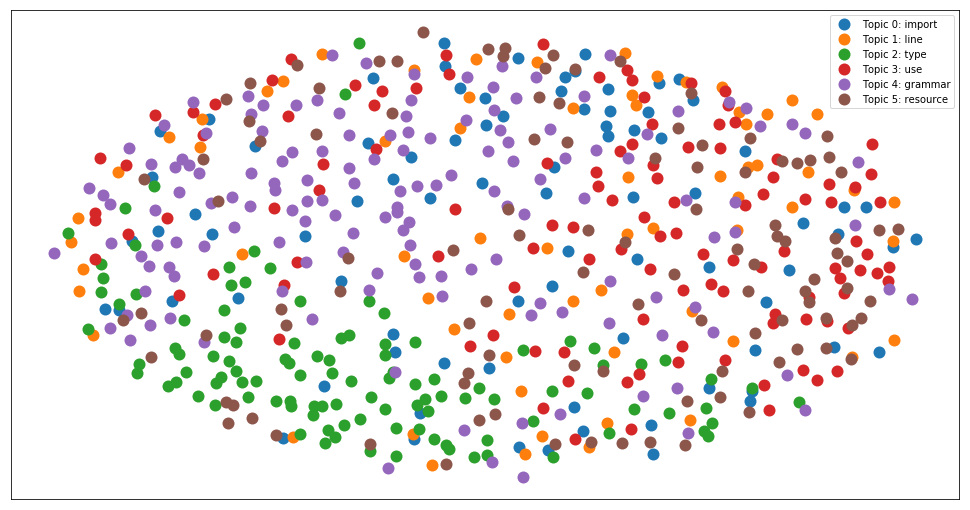

In [19]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
# df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=trimmedDF.loc[:,'id'],)) 
xs, ys = pos[:, 0], pos[:, 1]
df = pd.DataFrame(dict(x=xs, y=ys, label=trimmedDF.loc[:,'topic'], title=trimmedDF.loc[:,'id'],)) 

#group by cluster
groups = df.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
#            label=cluster_names[name], color=cluster_colors[name],
#            label=name,
            label=topic_labels[name],
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the bug id
#for i in range(len(df)):
#    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=8)  

plt.show() #show the plot


# Doc2Vec


In [49]:
import gensim
def read_corpus():
  for i, row in trimmedDF.iterrows():
    yield gensim.models.doc2vec.TaggedDocument(tokenize(row['text']), [row['id']])

train_corpus = list(read_corpus())

/opt/tools/anaconda/lib/python3.6/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
/opt/tools/anaconda/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [50]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)

In [51]:
model.build_vocab(train_corpus)

In [52]:
%time model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

CPU times: user 44 s, sys: 901 ms, total: 44.9 s
Wall time: 18.2 s


In [53]:
model.infer_vector(['hello', 'world'])

array([ 0.25824672, -0.03220039,  0.14304313, -0.02647677, -0.1454829 ,
       -0.05455263, -0.03433496,  0.24916117,  0.00771636, -0.11460485,
        0.02935058, -0.11878093, -0.24456902, -0.05020611, -0.18427646,
        0.03028828, -0.09611296,  0.00822129, -0.08758368,  0.02963678,
       -0.11485024, -0.10173851, -0.14399354,  0.01666812, -0.03719967,
       -0.04671728, -0.26501408, -0.18023945, -0.12788801,  0.01723314,
        0.4210442 , -0.29503354, -0.06830796,  0.03440053, -0.02062064,
       -0.03939977,  0.11596537,  0.16205622, -0.09261966,  0.319259  ,
       -0.06688394,  0.11074264, -0.11034197, -0.1452656 ,  0.06435984,
        0.00990463, -0.13979663,  0.19703075,  0.16134122, -0.23279226],
      dtype=float32)

In [54]:
import random
# Pick a random document from the test corpus and infer a vector from the model
doc_id = random.randint(0, len(train_corpus) - 1)
doc = train_corpus[doc_id]
text = trimmedDF.loc[trimmedDF['id'] == doc.tags[0]].iloc[0]['text']
print(doc.tags[0],text)

inferred_vector = model.infer_vector(doc.words)
sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))

print()
print(sims[1][0])
text = trimmedDF.loc[trimmedDF['id'] == sims[1][0]].iloc[0]['text']
print(doc.tags[0],text)


249464 [Resource] Implement MetaModelResource that provides metamodel from xtext input stream  In addition to XtextResource that produces a grammar model from a given xtext input stream a new XtextMetaModelResource should provide the metamodel directly. Its content elements contain EPackages of the inferred metamodel. Created attachment 114089
Solved SuperGrammar problem, first running tests Has the provided patch been applied? The patch seems to be applied or obsolete. fixed Closing bug which were set to RESOLVED before Eclipse Neon.0.

291022
249464 [Content Assist] Missing suggestion due to wrong context   Fixed in HEAD. Closing bug which were set to RESOLVED before Eclipse Neon.0.
